In [1]:
from pathlib import Path
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from matplotlib.collections import LineCollection
import seaborn as sns

import trompy as tp
import csv

VMH_colors_restricted = "#90219C"
VMH_colors_light = "#e56357"
VMH_colors_dark =  "#D9A441"
VMH_colors_sucralose = "#F4A6B1"

VMH_colors = ["#90219C",  "#D9A441", "#e56357", "#F4A6B1"]

PVH_colors_restricted = "#219C90"
PVH_colors_light = "#9C89B8" 
PVH_colors_dark = "#0059b3"
PVH_colors_sucralose = "#af9991"

PVH_colors =["#219C90", "#0059b3","#9C89B8","#af9991"]

In [2]:
DATAFOLDER = Path("C:/Data/hislight_pickles/")
FIGSFOLDER = Path("C:/Users/kvo019/OneDrive - UiT Office 365/Pipette 2/People/Linnea/Manuscripts/hislight paper/figures/figs_for_revised_version")
STATSFOLDER = Path("C:/Users/kvo019/OneDrive - UiT Office 365/Pipette 2/People/Linnea/Manuscripts/hislight paper/stats")

#VMH 
with open(DATAFOLDER / "HL3_restricted_dark.pickle", 'rb') as handle:
    VMH_restricted_dark = pickle.load(handle)

with open(DATAFOLDER / "HL3_adlib_dark.pickle", 'rb') as handle:
    VMH_adlib_dark = pickle.load(handle)

with open(DATAFOLDER / "HL3_adlib_light.pickle", 'rb') as handle:
    VMH_adlib_light = pickle.load(handle)

with open(DATAFOLDER / "HL3_adlib_sucralose.pickle", 'rb') as handle:
    VMH_adlib_sucralose = pickle.load(handle)
    
#PVH    
    
with open(DATAFOLDER / "restricted_dark.pickle", 'rb') as handle:
    PVH_restricted_dark = pickle.load(handle)

with open(DATAFOLDER / "adlib_dark.pickle", 'rb') as handle:
    PVH_adlib_dark = pickle.load(handle)

with open(DATAFOLDER / "adlib_light.pickle", 'rb') as handle:
    PVH_adlib_light = pickle.load(handle)

with open(DATAFOLDER / "adlib_sucralose.pickle", 'rb') as handle:
    PVH_adlib_sucralose = pickle.load(handle)

In [3]:
def get_list_of_mice(data):

    mice_to_exclude = ["HL313", "HL314", "HL315", "HL316", "HL317", "HL318", "HL306", "HL308",
                        "HL202", "HL205", "HL206", "HL211",
                        "HL301", "HL304", "HL305"]
    
    #"HL202", "HL205", "HL206", "HL211" have poor placements without virus in PVH
    #HL 306, 308 have no virus
    #HL301, HL304, HL305 have poor fiber placement
    #HL313 - HL318 are control mice
    
    list_of_mice = []

    for key, val in data.items():
        if val["mouse_ID"] not in list_of_mice and val["mouse_ID"] not in mice_to_exclude:
            list_of_mice.append(val["mouse_ID"])
            
    return list_of_mice

In [4]:
PVH_list_of_mice = []
VMH_list_of_mice = []

mice_to_exclude = ["HL313", "HL314", "HL315", "HL316", "HL317", "HL318", "HL306", "HL308",
                    "HL202", "HL205", "HL206", "HL211",
                    "HL301", "HL304", "HL305"]

#"HL202", "HL205", "HL206", "HL211" have poor placements without virus in PVH
#HL 306, 308 have no virus
#HL301, HL304, HL305 have poor fiber placement
#HL313 - HL318 are control mice


for key, val in PVH_restricted_dark.items():
    if val["mouse_ID"] not in mice_to_exclude:
        if val["mouse_ID"] not in PVH_list_of_mice:
            PVH_list_of_mice.append(val["mouse_ID"])
        
for key, val in VMH_restricted_dark.items():
    if val["mouse_ID"] not in mice_to_exclude:
        if val["mouse_ID"] not in VMH_list_of_mice:
            VMH_list_of_mice.append(val["mouse_ID"])

In [5]:
def get_snips(data, mice):
    all_snips = []  
    snip_counts = []  # List to store the count of snips for each mouse

    pre = 5
    post = 10
    mineventlength = 4
    binlength = 0.1
    for mouse in mice:
        snips_full = []  # List to collect snips for the current mouse
        for key, val in data.items():
            if val["mouse_ID"] == mouse:
                if len(val["licks"]) < 10:
                    continue
                lickdata = tp.lickCalc(val["licks"], minrunlength=3)
                snipper = tp.Snipper(
                    val["corrected"],
                    lickdata["rStart"],
                    end=lickdata["rEnd"],
                    fs=val["fs"],
                    pre=pre,
                    post=post,
                    binlength=binlength,
                    zscore=True
                )
                snipper.truncate_to_same_length(cols_to_add=10, mineventlength=4, eventbalance=[2, 2])
                snipper.find_potential_artifacts(threshold=12, method="absolute_diff", showplot=True, remove=True)
                snips_full.append(snipper.snips)
        
        try:
            snips_full = np.vstack(snips_full)
            all_snips.append(snips_full)  # Append the snips for this mouse
            snip_counts.append(snips_full.shape[0])  # Record the count of snips for this mouse
            print(f"Adding snips for mouse {mouse}: {snips_full.shape[0]} runs")
        except:
            print(f"No snips to concatenate for mouse {mouse}")
            snip_counts.append(0)  # Record zero snips if none were collected
    # Concatenate all snips across all mice into a single array
    if all_snips:
        all_snips = np.vstack(all_snips)
    else:
        all_snips = np.array([])  # Return an empty array if no snips were collected
    return all_snips, snip_counts

<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 1 potential artifacts.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL302: 40 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 1 potential artifacts.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL303: 38 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL307: 42 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL309: 19 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL310: 42 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL311: 54 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL312: 35 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL302: 19 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 1 potential artifacts.
Adding snips for mouse HL303: 23 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL307: 15 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL309: 10 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper


Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL311: 20 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL312: 14 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL302: 12 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL303: 22 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts fo

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

<class 'numpy.ndarray'>
Found 1 potential artifacts.
Adding snips for mouse HL302: 11 runs
<class 'numpy.ndarray'>
Found 1 potential artifacts.
Adding snips for mouse HL303: 16 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL307: 8 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL309: 8 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL310: 11 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL311: 11 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL312: 9 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL203: 18 runs
<class 'n

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL204: 53 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL207: 40 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 3 potential artifacts.
Adding snips for mouse HL208: 53 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL209: 43 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL210: 44 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 1 potential artifacts.


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Adding snips for mouse HL212: 33 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL203: 9 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL204: 23 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL207: 17 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL208: 23 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL209: 17 runs
<class 'numpy.ndarray'>
Found 0 potential a

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL212: 5 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL203: 13 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL204: 19 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL207: 22 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts fou

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


Adding snips for mouse HL204: 13 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL207: 15 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL208: 22 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL209: 7 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL210: 4 runs
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
Adding snips for mouse HL212: 5 runs


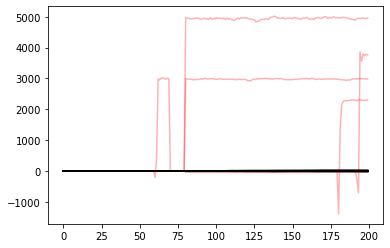

In [6]:
#getting snips

#VMH
VMH_restricted_full, VMH_restricted_count = get_snips(VMH_restricted_dark, VMH_list_of_mice)
VMH_dark_full, VMH_dark_count = get_snips(VMH_adlib_dark, VMH_list_of_mice)
VMH_light_full, VMH_light_count = get_snips(VMH_adlib_light, VMH_list_of_mice)
VMH_sucralose_full, VMH_sucralose_count = get_snips(VMH_adlib_sucralose, VMH_list_of_mice)

#PVH
PVH_restricted_full, PVH_restricted_count = get_snips(PVH_restricted_dark, PVH_list_of_mice)
PVH_dark_full, PVH_dark_count = get_snips(PVH_adlib_dark, PVH_list_of_mice)
PVH_light_full, PVH_light_count = get_snips(PVH_adlib_light, PVH_list_of_mice)
PVH_sucralose_full, PVH_sucralose_count = get_snips(PVH_adlib_sucralose, PVH_list_of_mice)

In [7]:
def consecutive_threshold(significant_times, min_consecutive):
    significant_periods = []
    start = None
    for i, is_significant in enumerate(significant_times):
        if is_significant:
            if start is None:
                start = i
        else:
            if start is not None:
                if i - start >= min_consecutive:
                    significant_periods.append((start, i))
                start = None
    # Check if the last period is significant
    if start is not None and len(significant_times) - start >= min_consecutive:
        significant_periods.append((start, len(significant_times)))
    return significant_periods

def analyze_peri_event_activity_with_bootstrapping(data, n_bootstraps=1000, min_consecutive=6):
    np.random.seed(42)
    bootstrap_means = np.zeros((n_bootstraps, data.shape[1]))
    
    # Perform bootstrapping (resample with replacement)
    for i in range(n_bootstraps):
        resample_indices = np.random.choice(data.shape[0], size=data.shape[0], replace=True)
        bootstrap_means[i, :] = np.mean(data[resample_indices, :], axis=0)
    
    # Calculate the 2.5th and 97.5th percentiles for the bootstrapped confidence intervals
    ci_lower = np.percentile(bootstrap_means, 2.5, axis=0)
    ci_upper = np.percentile(bootstrap_means, 97.5, axis=0)
    
    # Calculate the mean across all bootstrap samples (for plotting)
    means = np.mean(bootstrap_means, axis=0)
    
    # Flag the time points where the CI does not contain 0
    significant_above_zero = ci_lower > 0  # Significantly greater than zero
    significant_below_zero = ci_upper < 0  # Significantly less than zero
    # Combine significant times above and below zero
    significant_times = significant_above_zero | significant_below_zero
    # Apply consecutive thresholding
    significant_periods_above = consecutive_threshold(significant_above_zero, min_consecutive)
    significant_periods_below = consecutive_threshold(significant_below_zero, min_consecutive)
    significant_periods = consecutive_threshold(significant_times, min_consecutive)
    
    # Prepare the results dictionary
    results = {
        'significant_times_above': significant_above_zero,
        'significant_times_below': significant_below_zero,
        'significant_periods_above': significant_periods_above,
        'significant_periods_below': significant_periods_below,
        'significant_periods': significant_periods,
        'means': means,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }
    return results



In [8]:
BS_PVH_restricted = analyze_peri_event_activity_with_bootstrapping(PVH_restricted_full)
BS_PVH_dark = analyze_peri_event_activity_with_bootstrapping(PVH_dark_full)
BS_PVH_light = analyze_peri_event_activity_with_bootstrapping(PVH_light_full)
BS_PVH_sucralose = analyze_peri_event_activity_with_bootstrapping(PVH_sucralose_full)

BS_VMH_restricted = analyze_peri_event_activity_with_bootstrapping(VMH_restricted_full)
BS_VMH_dark = analyze_peri_event_activity_with_bootstrapping(VMH_dark_full)
BS_VMH_light = analyze_peri_event_activity_with_bootstrapping(VMH_light_full)
BS_VMH_sucralose = analyze_peri_event_activity_with_bootstrapping(VMH_sucralose_full)

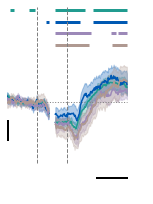

In [9]:
indices = np.arange(len(BS_PVH_restricted["means"]))
mask1 = indices <= 69
mask2 = indices >= 80

f, ax = plt.subplots(figsize=[2.5, 3.5])
# Plot the data
ax.plot(indices[mask1], BS_PVH_restricted["means"][mask1], color=PVH_colors_restricted)
ax.plot(indices[mask2], BS_PVH_restricted["means"][mask2], color=PVH_colors_restricted)

ax.plot(indices[mask1], BS_PVH_dark["means"][mask1], color=PVH_colors_dark)
ax.plot(indices[mask2], BS_PVH_dark["means"][mask2], color=PVH_colors_dark)

ax.plot(indices[mask1], BS_PVH_light["means"][mask1], color=PVH_colors_light)
ax.plot(indices[mask2], BS_PVH_light["means"][mask2], color=PVH_colors_light)

ax.plot(indices[mask1], BS_PVH_sucralose["means"][mask1], color=PVH_colors_sucralose)
ax.plot(indices[mask2], BS_PVH_sucralose["means"][mask2], color=PVH_colors_sucralose)

# Plot the confidence intervals using fill_between
ax.fill_between(indices[mask1], BS_PVH_restricted["ci_lower"][mask1], BS_PVH_restricted["ci_upper"][mask1], color=PVH_colors_restricted, alpha=0.3)
ax.fill_between(indices[mask2], BS_PVH_restricted["ci_lower"][mask2], BS_PVH_restricted["ci_upper"][mask2], color=PVH_colors_restricted, alpha=0.3)

ax.fill_between(indices[mask1],BS_PVH_dark["ci_lower"][mask1], BS_PVH_dark["ci_upper"][mask1], color=PVH_colors_dark, alpha=0.3)
ax.fill_between(indices[mask2],BS_PVH_dark["ci_lower"][mask2], BS_PVH_dark["ci_upper"][mask2], color=PVH_colors_dark, alpha=0.3)

ax.fill_between(indices[mask1],BS_PVH_light["ci_lower"][mask1], BS_PVH_light["ci_upper"][mask1], color=PVH_colors_light, alpha=0.3)
ax.fill_between(indices[mask2],BS_PVH_light["ci_lower"][mask2], BS_PVH_light["ci_upper"][mask2], color=PVH_colors_light, alpha=0.3)

ax.fill_between(indices[mask1],BS_PVH_sucralose["ci_lower"][mask1], BS_PVH_sucralose["ci_upper"][mask1], color=PVH_colors_sucralose, alpha=0.3)
ax.fill_between(indices[mask2],BS_PVH_sucralose["ci_lower"][mask2], BS_PVH_sucralose["ci_upper"][mask2], color=PVH_colors_sucralose, alpha=0.3)

# Highlight significant periods
significant_periods_restricted =  BS_PVH_restricted['significant_periods']
significant_periods_dark =  BS_PVH_dark['significant_periods']
significant_periods_light =  BS_PVH_light['significant_periods']
significant_periods_sucralose =  BS_PVH_sucralose['significant_periods']

for start, end in significant_periods_restricted:
    ax.hlines(y=4.8, xmin=start, xmax=end, color=PVH_colors_restricted, linewidth=3)
for start, end in significant_periods_dark:
    ax.hlines(y=4.2, xmin=start, xmax=end, color=PVH_colors_dark, linewidth=3)
for start, end in significant_periods_light:
    ax.hlines(y=3.6, xmin=start, xmax=end, color=PVH_colors_light, linewidth=3)
for start, end in significant_periods_sucralose:
    ax.hlines(y=3, xmin=start, xmax=end, color=PVH_colors_sucralose, linewidth=3)
    
# Add additional plot elements
ax.hlines(y=0, xmin=0, xmax=200, color="grey", linewidth=1, linestyle="dotted")
ax.vlines(x=50, ymin=-3.2, ymax=5, color="grey", linewidth=1, linestyle="--")
ax.vlines(x=100, ymin=-3.2, ymax=5, color="grey", linewidth=1, linestyle="--")

for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylim(-5, 5)
ax.set_xlim(0, 232)

#scale bars
ax.plot([150,200], [0.1, 0.1], linewidth=2, color="k", transform=blended_transform_factory(ax.transData, ax.transAxes))
ax.plot([2,2], [-1, -2], linewidth=2, color="k")

plt.show()

#f.savefig(FIGSFOLDER / "fig_5_PVH_different_conditions_bootstrap_4s.pdf")

In [10]:
print(BS_PVH_restricted['significant_periods'])
print(BS_PVH_dark['significant_periods'])
print(BS_PVH_light['significant_periods'])
print(BS_PVH_sucralose['significant_periods'])

[(5, 12), (37, 47), (80, 129), (143, 200)]
[(64, 70), (80, 121), (142, 200)]
[(80, 139), (173, 181), (185, 200)]
[(80, 136), (185, 200)]


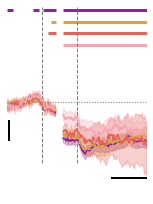

In [25]:
indices = np.arange(len(BS_VMH_restricted["means"]))
mask1 = indices <= 69
mask2 = indices >= 80
f, ax = plt.subplots(figsize=[2.5, 3.5])
# Plot the data for each condition
ax.plot(indices[mask1], BS_VMH_restricted["means"][mask1], color=VMH_colors_restricted)
ax.plot(indices[mask2], BS_VMH_restricted["means"][mask2], color=VMH_colors_restricted)
ax.plot(indices[mask1], BS_VMH_dark["means"][mask1], color=VMH_colors_dark)
ax.plot(indices[mask2], BS_VMH_dark["means"][mask2], color=VMH_colors_dark)
ax.plot(indices[mask1], BS_VMH_light["means"][mask1], color=VMH_colors_light)
ax.plot(indices[mask2], BS_VMH_light["means"][mask2], color=VMH_colors_light)
ax.plot(indices[mask1], BS_VMH_sucralose["means"][mask1], color=VMH_colors_sucralose)
ax.plot(indices[mask2], BS_VMH_sucralose["means"][mask2], color=VMH_colors_sucralose)
# Plot the confidence intervals using fill_between
ax.fill_between(indices[mask1], BS_VMH_restricted["ci_lower"][mask1], BS_VMH_restricted["ci_upper"][mask1], color=VMH_colors_restricted, alpha=0.3)
ax.fill_between(indices[mask2], BS_VMH_restricted["ci_lower"][mask2], BS_VMH_restricted["ci_upper"][mask2], color=VMH_colors_restricted, alpha=0.3)
ax.fill_between(indices[mask1], BS_VMH_dark["ci_lower"][mask1], BS_VMH_dark["ci_upper"][mask1], color=VMH_colors_dark, alpha=0.3)
ax.fill_between(indices[mask2], BS_VMH_dark["ci_lower"][mask2], BS_VMH_dark["ci_upper"][mask2], color=VMH_colors_dark, alpha=0.3)
ax.fill_between(indices[mask1], BS_VMH_light["ci_lower"][mask1], BS_VMH_light["ci_upper"][mask1], color=VMH_colors_light, alpha=0.3)
ax.fill_between(indices[mask2], BS_VMH_light["ci_lower"][mask2], BS_VMH_light["ci_upper"][mask2], color=VMH_colors_light, alpha=0.3)
ax.fill_between(indices[mask1], BS_VMH_sucralose["ci_lower"][mask1], BS_VMH_sucralose["ci_upper"][mask1], color=VMH_colors_sucralose, alpha=0.3)
ax.fill_between(indices[mask2], BS_VMH_sucralose["ci_lower"][mask2], BS_VMH_sucralose["ci_upper"][mask2], color=VMH_colors_sucralose, alpha=0.3)
# Highlight significant periods
significant_periods_restricted = BS_VMH_restricted['significant_periods']
significant_periods_dark = BS_VMH_dark['significant_periods']
significant_periods_light = BS_VMH_light['significant_periods']
significant_periods_sucralose = BS_VMH_sucralose['significant_periods']
for start, end in significant_periods_restricted:
    ax.hlines(y=4.8, xmin=start, xmax=end, color=VMH_colors_restricted, linewidth=3)
for start, end in significant_periods_dark:
    ax.hlines(y=4.2, xmin=start, xmax=end, color=VMH_colors_dark, linewidth=3)
for start, end in significant_periods_light:
    ax.hlines(y=3.6, xmin=start, xmax=end, color=VMH_colors_light, linewidth=3)
for start, end in significant_periods_sucralose:
    ax.hlines(y=3.0, xmin=start, xmax=end, color=VMH_colors_sucralose, linewidth=3)
    
# Add additional plot elements
ax.hlines(y=0, xmin=0, xmax=200, color="grey", linewidth=1, linestyle="dotted")
ax.vlines(x=50, ymin=-3.2, ymax=5, color="grey", linewidth=1, linestyle="--")
ax.vlines(x=100, ymin=-3.2, ymax=5, color="grey", linewidth=1, linestyle="--")

for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylim(-5, 5)
ax.set_xlim(0, 200)
# Scale bars
ax.plot([150, 200], [0.1, 0.1], linewidth=2, color="k", transform=blended_transform_factory(ax.transData, ax.transAxes))
ax.plot([2, 2], [-1, -2], linewidth=2, color="k")
plt.show()

f.savefig(FIGSFOLDER / "fig_5_VMH_different_conditions_bootstrap_4s.pdf")

In [12]:
print(BS_VMH_restricted['significant_periods'])
print(BS_VMH_dark['significant_periods'])
print(BS_VMH_light['significant_periods'])
print(BS_VMH_sucralose['significant_periods'])

[(0, 8), (37, 46), (52, 70), (80, 200)]
[(63, 70), (80, 200)]
[(59, 70), (80, 200)]
[(80, 200)]


In [13]:
print("PVH DATA")
print("Restricted total runs:", sum(PVH_restricted_count))
print("Restricted runs per mouse:", PVH_restricted_count)

print("Dark total runs:", sum(PVH_dark_count))
print("Dark runs per mouse:", PVH_dark_count)

print("Light total runs:", sum(PVH_light_count))
print("Light runs per mouse:", PVH_light_count)

print("Sucralose total runs:", sum(PVH_sucralose_count))
print("Sucralose runs per mouse:", PVH_sucralose_count)

PVH DATA
Restricted total runs: 284
Restricted runs per mouse: [18, 53, 40, 53, 43, 44, 33]
Dark total runs: 107
Dark runs per mouse: [9, 23, 17, 23, 17, 13, 5]
Light total runs: 104
Light runs per mouse: [13, 19, 22, 13, 11, 11, 15]
Sucralose total runs: 85
Sucralose runs per mouse: [19, 13, 15, 22, 7, 4, 5]


In [14]:
print("VMH DATA")
print("Restricted total runs:", sum(VMH_restricted_count))
print("Restricted runs per mouse:", VMH_restricted_count)

print("Dark total runs:", sum(VMH_dark_count))
print("Dark runs per mouse:", VMH_dark_count)

print("Light total runs:", sum(VMH_light_count))
print("Light runs per mouse:", VMH_light_count)

print("Sucralose total runs:", sum(VMH_sucralose_count))
print("Sucralose runs per mouse:", VMH_sucralose_count)

VMH DATA
Restricted total runs: 270
Restricted runs per mouse: [40, 38, 42, 19, 42, 54, 35]
Dark total runs: 126
Dark runs per mouse: [19, 23, 15, 10, 25, 20, 14]
Light total runs: 77
Light runs per mouse: [12, 22, 7, 2, 16, 12, 6]
Sucralose total runs: 74
Sucralose runs per mouse: [11, 16, 8, 8, 11, 11, 9]
